## Part I: Data Pre-processing

In [5]:
import pandas as pd

In [ ]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [ ]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

In [6]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

questions = []
categories = []
sub_categories = []

first_category = "Semantic"
second_category = "Syntatic"

num = 0

for line in data:
    if line[0] == ":":
        if num < 5:
            category = first_category
            sub_category = line
        else:
            category = second_category
            sub_category = line
        num += 1
    else:
        questions.append(line)
        categories.append(category)
        sub_categories.append(sub_category)

In [7]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)


In [8]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries


In [9]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [8]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [9]:
data = pd.read_csv("questions-words.csv")

In [ ]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

In [ ]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
    # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
    # You should also preserve the gold answers during iterations for evaluations later.
    """ Hints
    # Unpack the analogy (e.g., "man", "woman", "king", "queen")
    # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
    # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
    # Mikolov et al., 2013: big - biggest and small - smallest
    # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
    """
    word_a, word_b, word_c, word_d = analogy.lower().split()
    try:
        predicted_word = model.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)[0][0]
    except KeyError as e:
        predicted_word = None
    preds.append(predicted_word)
    golds.append(word_d)

In [12]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 65.3399481339497%
Category: Syntatic, Accuracy: 61.255269320843084%
Sub-Category: capital-common-countries, Accuracy: 93.87351778656127%
Sub-Category: capital-world, Accuracy: 88.94783377541998%
Sub-Category: currency, Accuracy: 14.203233256351039%
Sub-Category: city-in-state, Accuracy: 30.806647750304013%
Sub-Category: family, Accuracy: 81.62055335968378%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category: gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category: gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category: gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category: gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category: gram6-nationality-adjective, Accuracy: 87.86741713570981%
Sub-Category: gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category: gram8-plural, Accuracy: 71.996996996997%
Sub-Category: gram9-plural-verbs, Accuracy: 58.39080459770115%


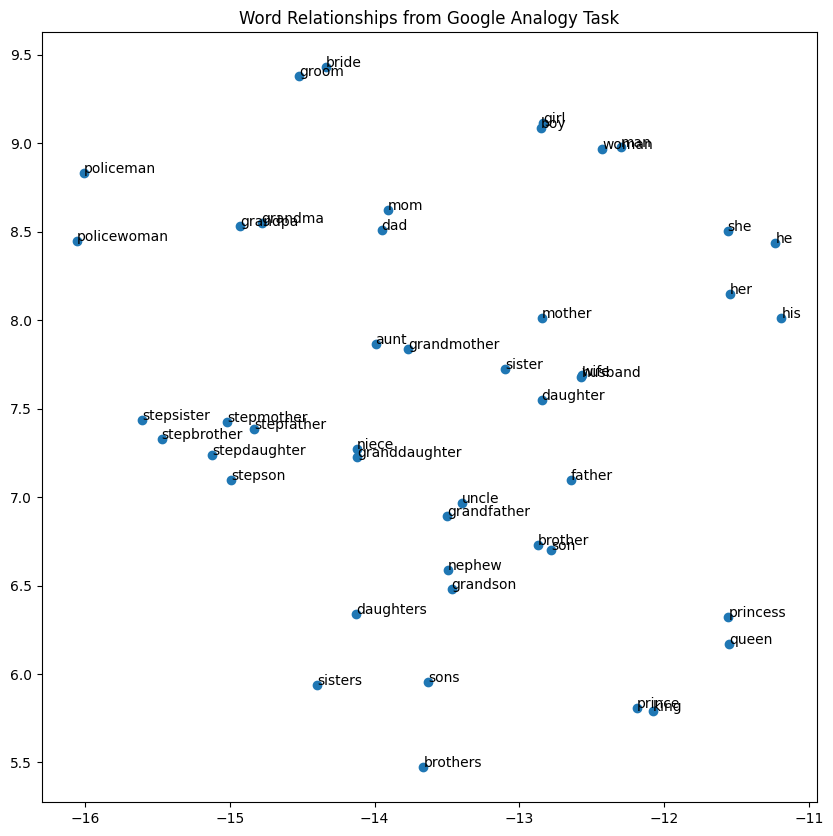

In [16]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
# by gemini

data_filter = data[data["SubCategory"] == SUB_CATEGORY]

word_list = []
for question in data_filter["Question"]:
    words = question.split()
    word_list.extend(words)

all_words = list(set(word_list))

word_vectors = []
word_labels = []
for word in all_words:
    if word in model:
        word_vectors.append(model[word])
        word_labels.append(word)

word_vectors = np.array(word_vectors)
word_labels = np.array(word_labels)

tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o')
for i, word in enumerate(word_labels):
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.title("Word Relationships from Google Analogy Task")
plt.savefig("word_relationships.png", bbox_inches="tight")
plt.show()

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [ ]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [ ]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [ ]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [18]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
output_path = "wiki_texts_combined_preprocessed.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
        lines = f.readlines()
        sampled_lines = random.sample(lines, int(0.2 * len(lines)))
        for line in sampled_lines:
            output_file.write(line)

In [ ]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

def preprocessing(document):
    tokens = document.split()
    lowercase_tokens = [token.lower() for token in tokens]

    stopwords_set = set(stopwords.words('english'))
    filtered_tokens = [token for token in lowercase_tokens if token not in stopwords_set]

    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    stemmed_tokens = [token for token in stemmed_tokens if token not in stopwords_set]

    tokens = [token for token in stemmed_tokens if not token.isdigit() and len(token) > 1]

    return tokens

def preprocessing_without_stemmed(document):
    tokens = document.split()
    lowercase_tokens = [token.lower() for token in tokens]

    stopwords_set = set(stopwords.words('english'))
    filtered_tokens = [token for token in lowercase_tokens if token not in stopwords_set]

    tokens = [token for token in filtered_tokens if not token.isdigit() and len(token) > 1]

    return tokens

In [2]:
output_path = "wiki_texts_combined_preprocessed.txt"
output_processed_path = "wiki_texts_processed.txt"
output_processed_stemmed_path = "wiki_texts_processed_without_stemmed.txt"

with open(output_path, "r", encoding="utf-8") as f:
    with open(output_processed_path, "w", encoding="utf-8") as output_file:
        for line in f:
            processed_line = preprocessing_without_stemmed(line)
            output_file.write(" ".join(processed_line) + "\n")

In [32]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing

sentences = LineSentence(output_processed_path)
model = Word2Vec(vector_size=200, window=5, min_count=1, workers=multiprocessing.cpu_count())
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)
model.save("word2vec6.model")

In [33]:
data = pd.read_csv("questions-words.csv")

In [35]:
from gensim.models import Word2Vec

preds = []
golds = []

model = Word2Vec.load("word2vec6.model")

for analogy in tqdm(data["Question"]):
    # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
    # You should also preserve the gold answers during iterations for evaluations later.
    """ Hints
    # Unpack the analogy (e.g., "man", "woman", "king", "queen")
    # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
    # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
    # Mikolov et al., 2013: big - biggest and small - smallest
    # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
    """
    word_a, word_b, word_c, word_d = analogy.lower().split()
    try:
        predicted_word = model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)[0][0]
    except KeyError as e:
        predicted_word = None
    preds.append(predicted_word)
    golds.append(word_d)

100%|██████████| 19544/19544 [41:46<00:00,  7.80it/s]


In [36]:
def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 72.96200248055024%
Category: Syntatic, Accuracy: 61.29274004683841%
Sub-Category: capital-common-countries, Accuracy: 89.9209486166008%
Sub-Category: capital-world, Accuracy: 84.72590627763041%
Sub-Category: currency, Accuracy: 14.89607390300231%
Sub-Category: city-in-state, Accuracy: 67.73408998783948%
Sub-Category: family, Accuracy: 75.69169960474308%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 27.82258064516129%
Sub-Category: gram2-opposite, Accuracy: 22.29064039408867%
Sub-Category: gram3-comparative, Accuracy: 82.43243243243244%
Sub-Category: gram4-superlative, Accuracy: 51.69340463458111%
Sub-Category: gram5-present-participle, Accuracy: 53.78787878787878%
Sub-Category: gram6-nationality-adjective, Accuracy: 87.17948717948718%
Sub-Category: gram7-past-tense, Accuracy: 61.98717948717949%
Sub-Category: gram8-plural, Accuracy: 74.69969969969969%
Sub-Category: gram9-plural-verbs, Accuracy: 55.632183908045974%


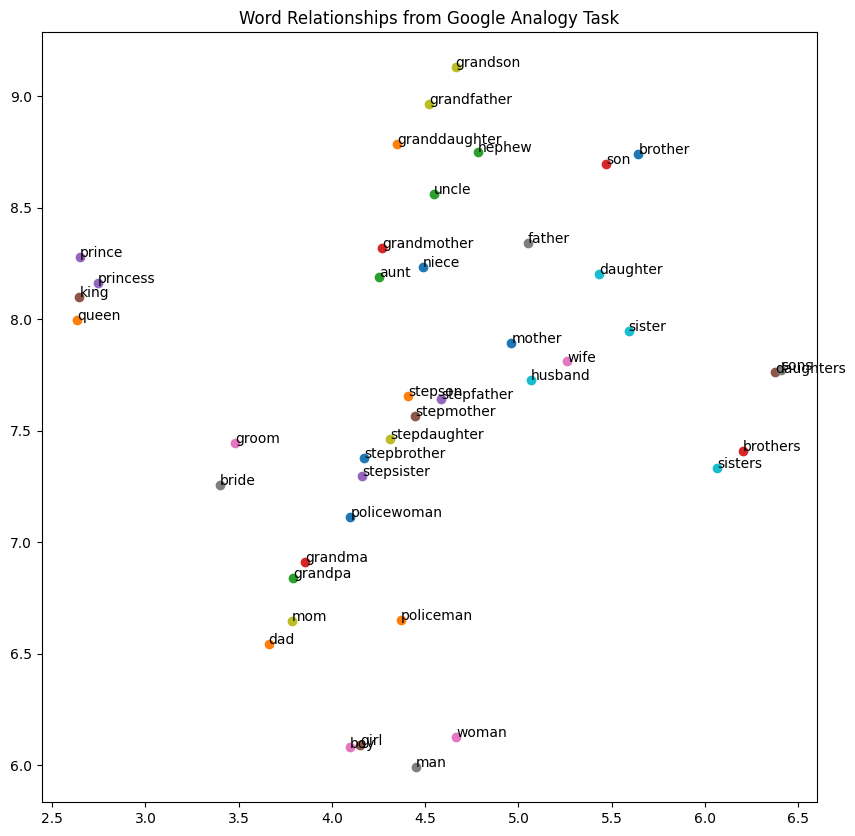

In [37]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`
data = data[data["SubCategory"] == SUB_CATEGORY]

all_words = set()
for question in data["Question"]:
    words = question.split()
    all_words.update(words)

word_vectors = []
word_labels = []
for word in all_words:
    if word in model.wv:
        word_vectors.append(model.wv[word])
        word_labels.append(word)

word_vectors = np.array(word_vectors)

tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 10))
for i, word in enumerate(word_labels):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.title("Word Relationships from Google Analogy Task")
plt.savefig("word_relationships.png", bbox_inches="tight")
plt.show()